In [1]:
from audiot import *

In [2]:
sr = 44100
total_duration = 1
event_duration = 0.8
start = 0.1

f0 = 440
f1 = 880

alpha = 0.8

source_signal = np.zeros(int(sr * total_duration))
target_signal = np.zeros_like(source_signal)
expected_signal = np.zeros_like(source_signal)

for f in range(int(event_duration * sr)):
    source_signal[int(start * sr) + f] = np.sin(2*np.pi*f*f0 / sr)
    source_signal[int(start * sr) + f] += 0.5*np.sin(2*np.pi*f*f0*2 / sr)
    target_signal[int(start * sr) + f] = np.sin(2*np.pi*f*f1 / sr)
    target_signal[int(start * sr) + f] += 0.3*np.sin(2*np.pi*f*f1*2 / sr)
    expected_signal[int(start *sr) + f] = np.sin(2*np.pi*f*((1 - alpha)*f0 + alpha*f1) / sr)

smooth_len = 2000
if smooth_len > 0:
    smoothing = np.linspace(0, 1, smooth_len)
    source_signal[int(start * sr):smooth_len + int(start * sr)] *= smoothing
    source_signal[int((start + event_duration) * sr)-smooth_len:int((start + event_duration) * sr)] *= np.flip(smoothing)
    target_signal[int(start * sr):smooth_len + int(start * sr)] *= smoothing
    target_signal[int((start + event_duration) * sr)-smooth_len:int((start + event_duration) * sr)] *= np.flip(smoothing)
    expected_signal[int(start * sr):smooth_len + int(start * sr)] *= smoothing
    expected_signal[int((start + event_duration) * sr)-smooth_len:int((start + event_duration) * sr)] *= np.flip(smoothing)

signals = [source_signal, target_signal, expected_signal]
titles = ['source', 'target', 'expected']
audio_widgets = [audio_widget(signal, title) for signal, title in zip(signals, titles)]

grid = widgets.VBox(audio_widgets)
grid

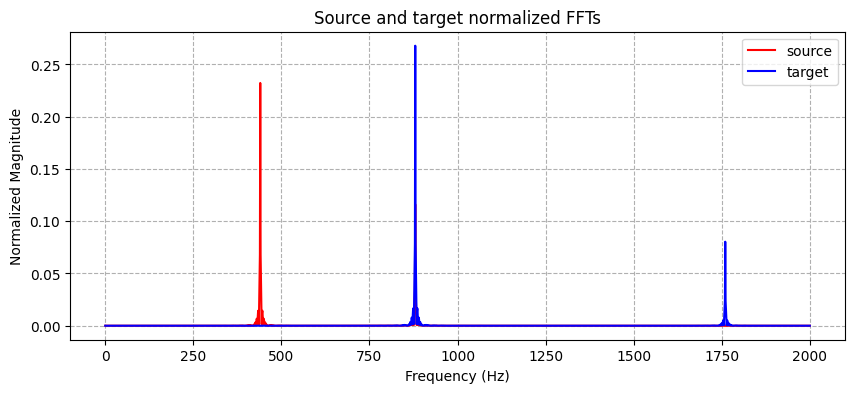

In [3]:
max_frequency = 2000

source_fft, support = fft(source_signal, sr=sr, return_support=True, max_frequency=max_frequency)
target_fft = fft(target_signal, sr=sr, max_frequency=max_frequency)

source = np.abs(source_fft) / np.sum(np.abs(source_fft))
target = np.abs(target_fft) / np.sum(np.abs(target_fft))

plot_signals(support, signals=[source, target], labels=['source', 'target'], title='Source and target normalized FFTs', colors=['r', 'b'])

/tmp/ipykernel_54936/1473781331.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.abs(f_s - f_t)**2 / f_s
/tmp/ipykernel_54936/1473781331.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  return np.abs(f_s - f_t)**2 / f_s


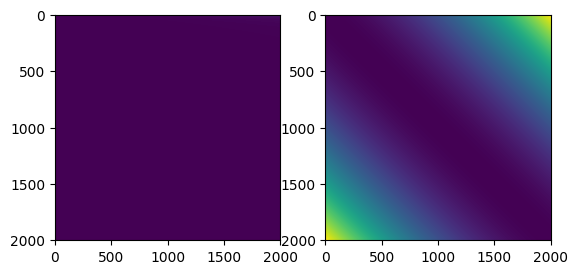

In [4]:
# Optimal transport

def dist1(f_s, f_t):
    return (f_s - f_t)**2 / (f_s * f_t)

def dist2(f_s, f_t):
    return np.abs(f_s - f_t)**2 / f_s

def dist3(f_s, f_t):
    return 1 / (f_s - f_t)**2

def dist4(f_s, f_t):
    return (f_s - f_t)**2


def normalized_cost_matrix(support, dist, meth=None):
        
    M = cost_matrix(support, dist=dist)

    max_value = np.nanmax(M[np.isfinite(M)])

    M[np.isinf(M)] = max_value
    M[np.isnan(M)] = max_value

    if meth == 'sum':
        for i in range(M.shape[0]):
            M[i] = M[i] / np.sum(M)
    if meth == 'rowsum':
        for i in range(M.shape[0]):
            M[i] = M[i] / np.sum(M[i])
            
    if meth == 'max':
        for i in range(M.shape[0]):
            M[i] = M[i] / np.max(M)

    if meth == 'rowmax':
        for i in range(M.shape[0]):
            M[i] = M[i] / np.max(M[i])

    if meth == None:
        return M

    return M

M1 = normalized_cost_matrix(support, dist2)
M2 = normalized_cost_matrix(support, dist4)

plt.subplot(1,2,1)
plt.imshow(M1)
plt.subplot(1,2,2)
plt.imshow(M2)

In [5]:
def complex_interpolation(interpolation, source, target, alpha):
    phase = (1 - alpha) * np.angle(source) + alpha * np.angle(target)

    return interpolation * np.exp(1j * phase)

In [6]:
interpolation_1, plan_1 = emd(support, source, target, M1, alpha)
interpolation_2, plan_2 = emd(support, source, target, M2, alpha)

complex_interpolation_1 = np.fft.irfft(complex_interpolation(interpolation_1, source_fft, target_fft, alpha), n=source_signal.shape[0])
complex_interpolation_2 = np.fft.irfft(complex_interpolation(interpolation_2, source_fft, target_fft, alpha), n=source_signal.shape[0])

signals = [source_signal, target_signal, expected_signal, complex_interpolation_1, complex_interpolation_2]
titles = ['source', 'target', 'expected', 'interpolation 1' , 'interpolation 2']
audio_widgets = [audio_widget(signal, title) for signal, title in zip(signals, titles)]

grid = widgets.VBox(audio_widgets)
grid

/home/dva1105/Documents/memoire-master/audio_1D_transport/.venv/lib/python3.10/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


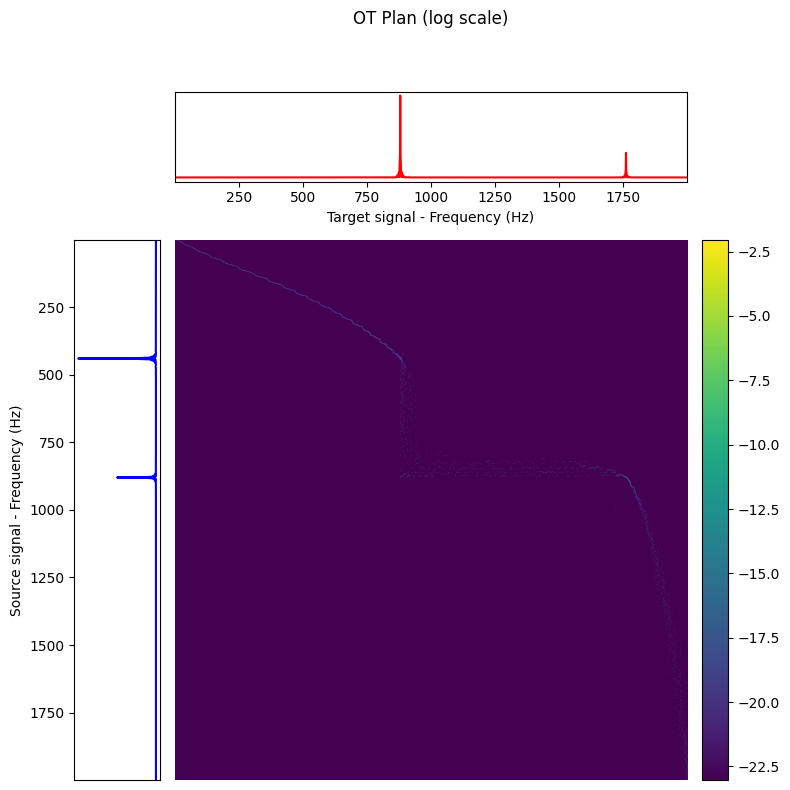

In [7]:
source_freq_start=0
source_freq_end=-1
target_freq_start=0
target_freq_end=-1
plot_plan_spectra(support, 
                  source, 
                  target, 
                  plan_1, 
                  source_freq_start=source_freq_start, 
                  source_freq_end=source_freq_end, 
                  target_freq_start=target_freq_start, 
                  target_freq_end=target_freq_end, 
                  log=True, 
                  epsilon=1e-10)


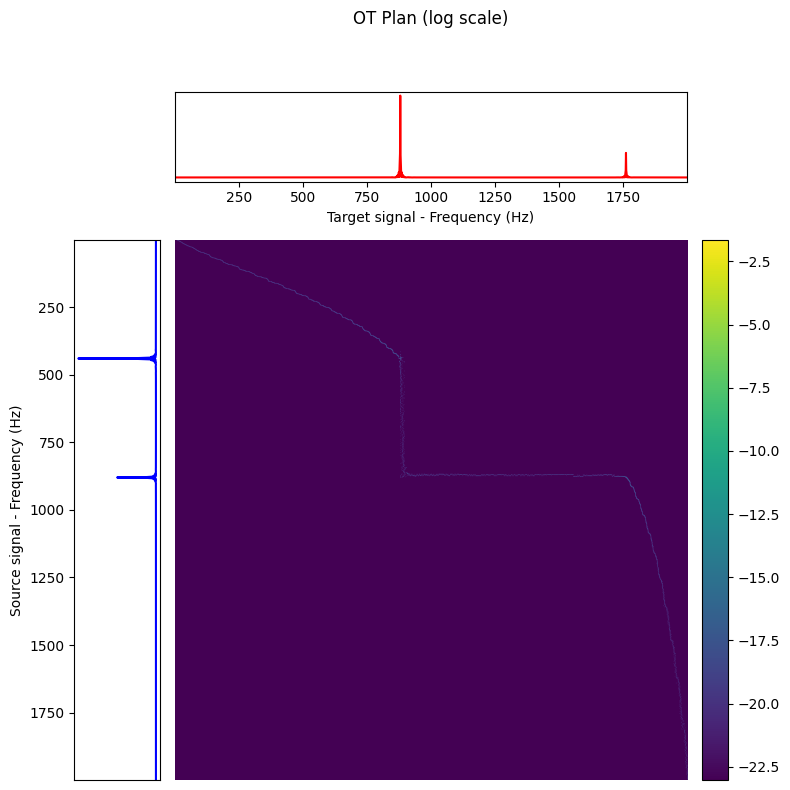

In [8]:
source_freq_start=0
source_freq_end=-1
target_freq_start=0
target_freq_end=-1
plot_plan_spectra(support, 
                  source, 
                  target, 
                  plan_2, 
                  source_freq_start=source_freq_start, 
                  source_freq_end=source_freq_end, 
                  target_freq_start=target_freq_start, 
                  target_freq_end=target_freq_end, 
                  log=True, 
                  epsilon=1e-10)


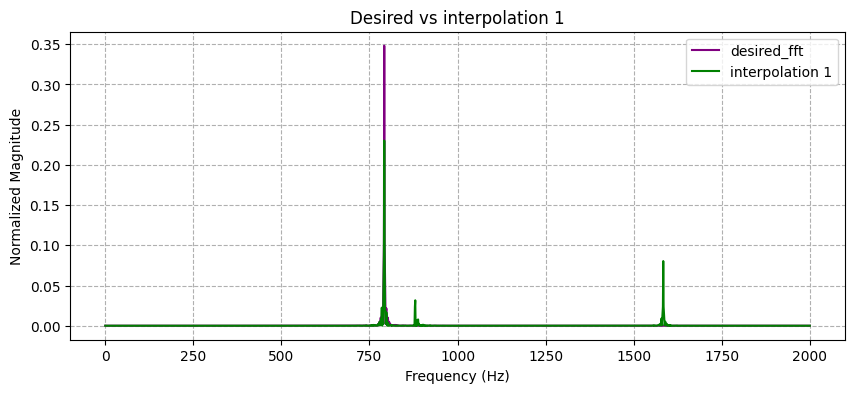

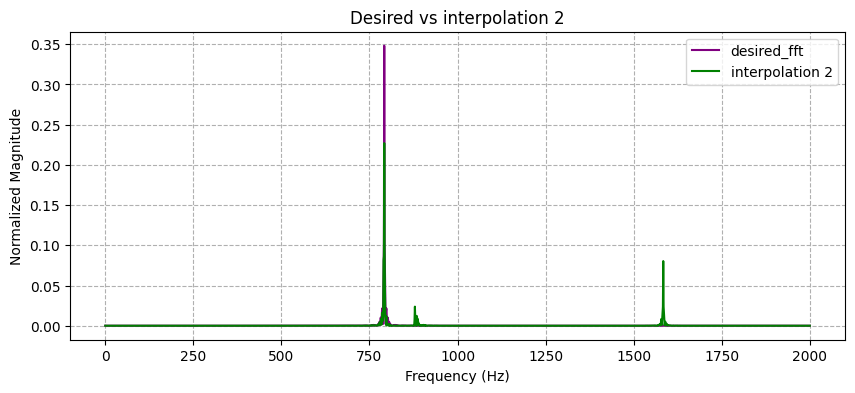

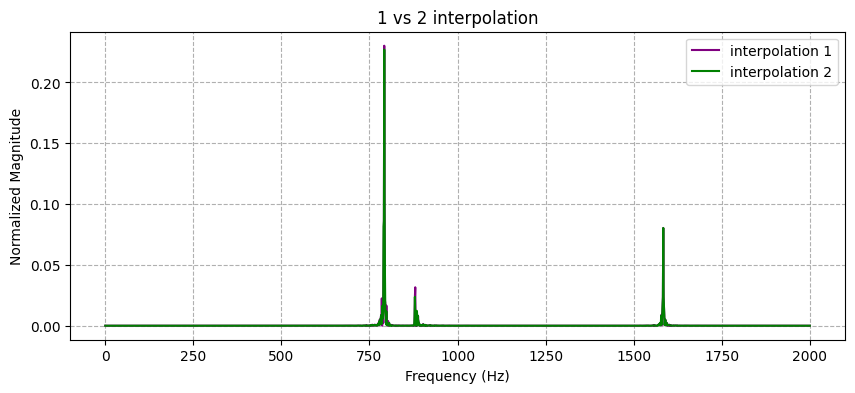

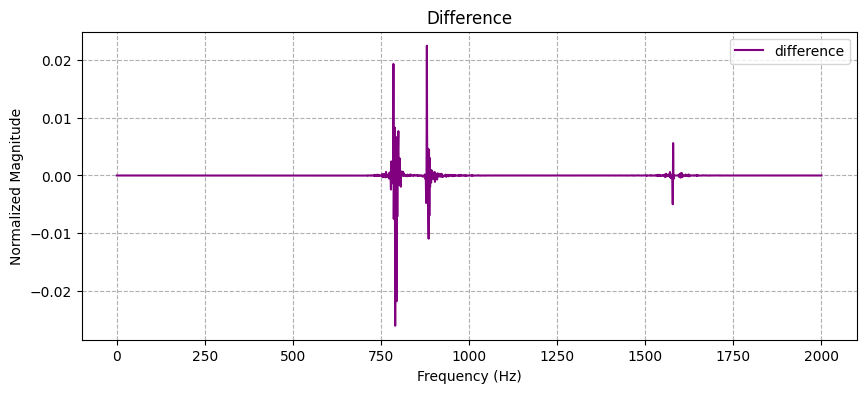

In [9]:
desired_fft = fft_normalized(expected_signal, sr=sr, max_frequency=max_frequency)

plot_signals(support, signals=[desired_fft, interpolation_1], labels=['desired_fft', 'interpolation 1'], title='Desired vs interpolation 1', colors=['purple', 'g'])
plot_signals(support, signals=[desired_fft, interpolation_2], labels=['desired_fft', 'interpolation 2'], title='Desired vs interpolation 2', colors=['purple', 'g'])
plot_signals(support, signals=[interpolation_1, interpolation_2], labels=['interpolation 1', 'interpolation 2'], title='1 vs 2 interpolation', colors=['purple', 'g'])
plot_signals(support, signals=[interpolation_1 - interpolation_2], labels=['difference'], title='Difference', colors=['purple', 'g'])


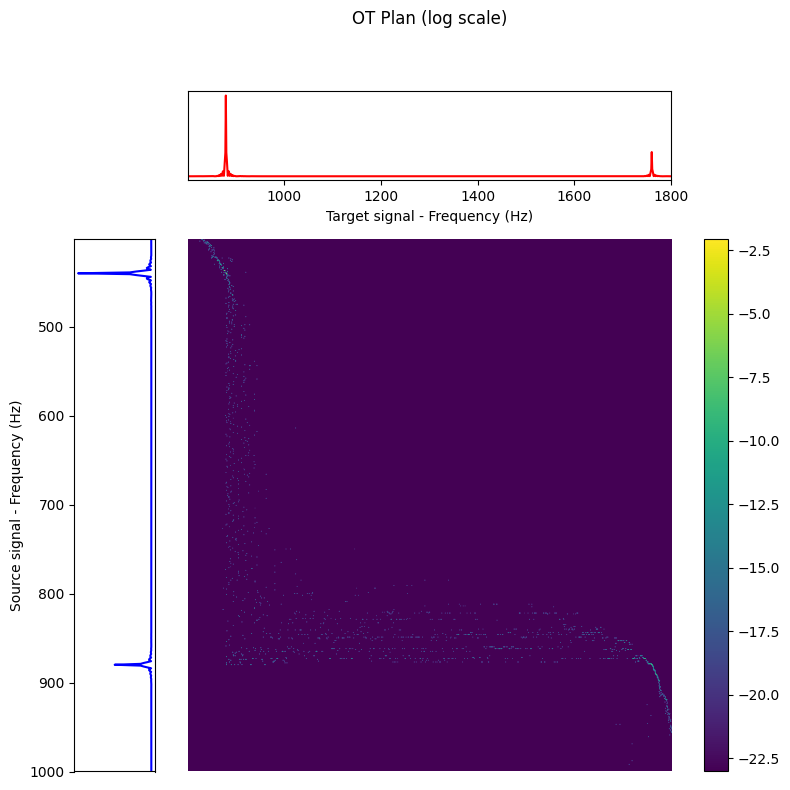

In [10]:
source_freq_start=400
source_freq_end=1000
target_freq_start=800
target_freq_end=1800
plot_plan_spectra(support, 
                  source, 
                  target, 
                  plan_1, 
                  source_freq_start=source_freq_start, 
                  source_freq_end=source_freq_end, 
                  target_freq_start=target_freq_start, 
                  target_freq_end=target_freq_end, 
                  log=True, 
                  epsilon=1e-10)


/home/dva1105/Documents/memoire-master/audio_1D_transport/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/dva1105/Documents/memoire-master/audio_1D_transport/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


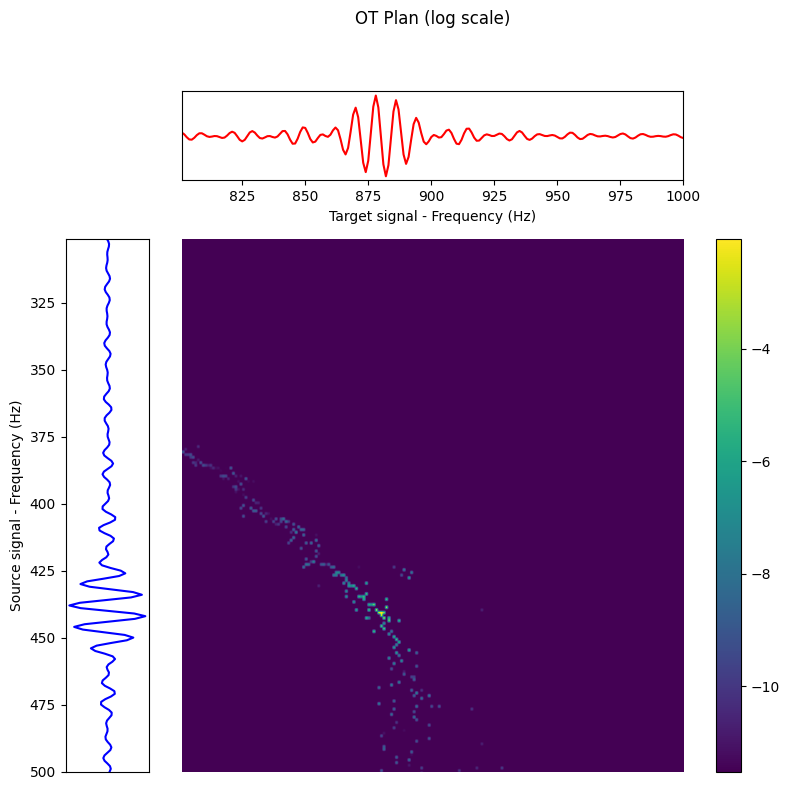

In [11]:
source_freq_start=300
source_freq_end=500
target_freq_start=800
target_freq_end=1000
plot_plan_spectra(support, 
                  source_fft, 
                  target_fft, 
                  plan_1, 
                  source_freq_start=source_freq_start, 
                  source_freq_end=source_freq_end, 
                  target_freq_start=target_freq_start, 
                  target_freq_end=target_freq_end, 
                  log=True, 
                  epsilon=1e-5)


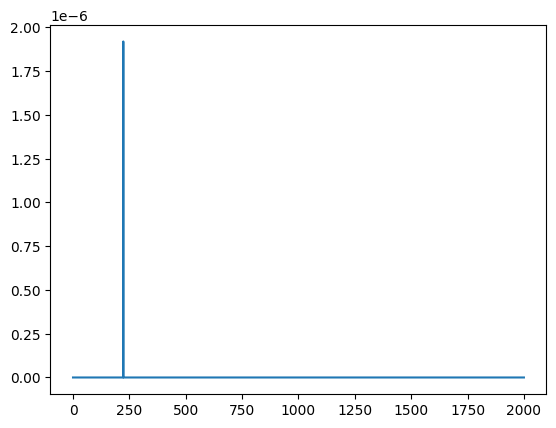

In [12]:
plt.plot(plan_1[:, frequency_to_index(support, 523)])

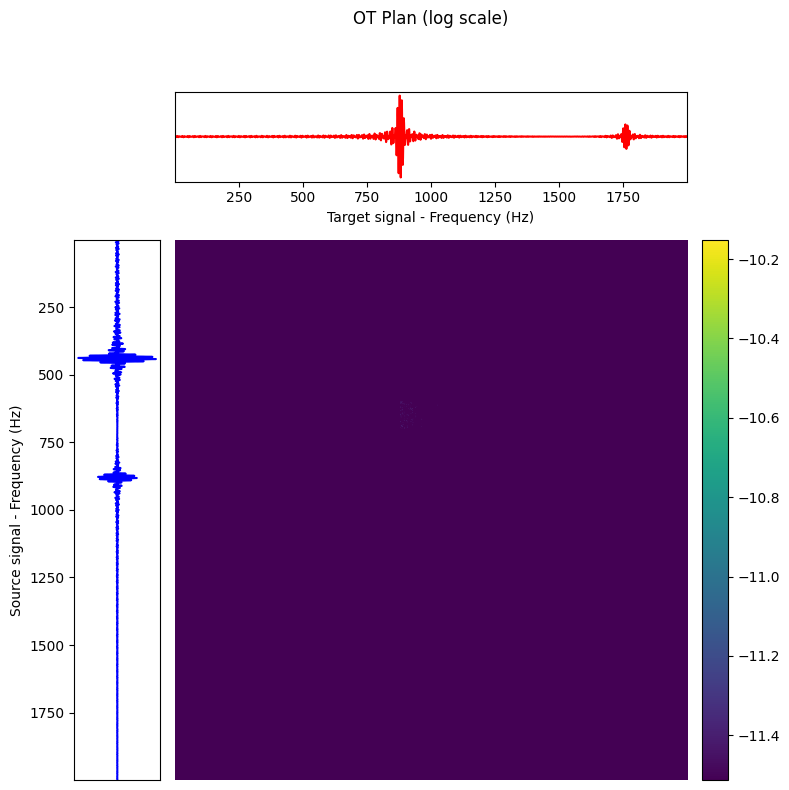

In [13]:
source_freq_start = frequency_to_index(support, 600)
source_freq_end = frequency_to_index(support, 700)
target_freq_start = frequency_to_index(support, 0)
target_freq_end = frequency_to_index(support, -1)
cut_plan = np.zeros_like(plan_1)
cut_plan[source_freq_start:source_freq_end, target_freq_start:target_freq_end] = plan_1[source_freq_start:source_freq_end, target_freq_start:target_freq_end]

source_freq_start=0
source_freq_end=-1
target_freq_start=0
target_freq_end=-1
plot_plan_spectra(support, 
                  source_fft, 
                  target_fft, 
                  cut_plan, 
                  source_freq_start=source_freq_start, 
                  source_freq_end=source_freq_end, 
                  target_freq_start=target_freq_start, 
                  target_freq_end=target_freq_end, 
                  log=True, 
                  epsilon=1e-5)


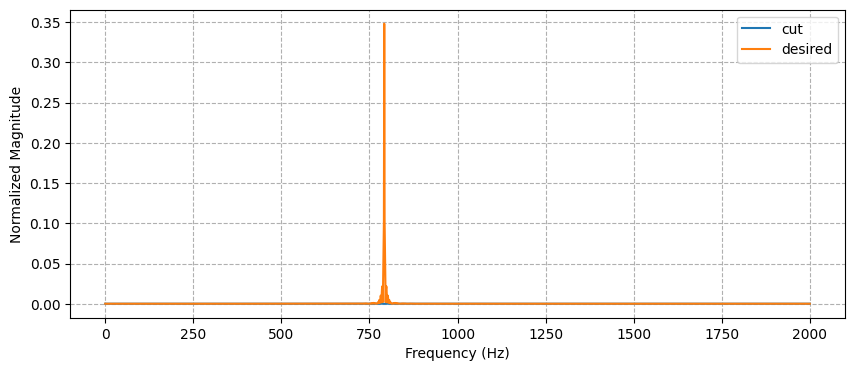

In [15]:
cut_plan = csr_matrix(cut_plan)
cut_interpolation = np.zeros(len(support))
row, col = cut_plan.nonzero()

for f_s, f_t in zip(row, col):
    index = interpolate_frequency(f_s, f_t, alpha=alpha)
    cut_interpolation[index] += cut_plan[f_s, f_t]

cut_plan = np.array(cut_plan.todense())

plot_signals(support, [cut_interpolation, desired_fft], ['cut', 'desired'])